In [1]:
import tensorflow as tf
import librosa
import os
from IPython.display import display, Audio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import argparse
from tensorflow.contrib import rnn

In [2]:
CONTENT_FILENAME = "neural-style-audio-tf/inputs/bach_violin.mp3"
STYLE_FILENAME = "neural-style-audio-tf/inputs/elgar_cello.mp3"

display(Audio(CONTENT_FILENAME))
display(Audio(STYLE_FILENAME))

In [3]:
# Reads wav file and produces spectrum
# Fourier phases are ignored
N_FFT = 2048
def read_audio_spectrum(filename):
    x, fs = librosa.load(filename)
    S = librosa.stft(x, N_FFT)
    p = np.angle(S)
    
    S = np.log1p(np.abs(S[:,:430]))  
    return S, fs



In [4]:
# get the spectograms for the content and style references
a_content, fs = read_audio_spectrum(CONTENT_FILENAME)
a_style, fs = read_audio_spectrum(STYLE_FILENAME)

N_CHANNELS = a_content.shape[0]
N_SAMPLES = a_content.shape[1]
a_style = a_style[:N_CHANNELS, :N_SAMPLES]

print np.shape(a_content)

num_features = N_CHANNELS # size of each input vector
time_steps = N_SAMPLES # number of input vectors to expect

num_hidden_units = 1025 # the frequency
# n_classes = 10 # not sure what this for - as outputs are usually probability layers
batch_size = 1
learning_rate = .001

# maybe transpose the spectogram - at each timestemp, process each 'frequency layer'
# a_content = np.transpose(a_content)
# a_content = np.reshape(a_content, (1, time_steps, N_SAMPLES))
# print np.shape(a_content)
# a_style = np.transpose(a_style)

(1025, 430)


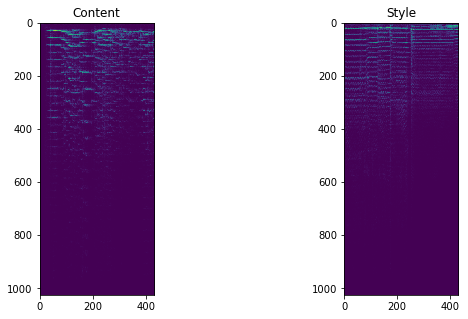

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Content')
plt.imshow(a_content[:,:]) # Clipping images
plt.subplot(1, 2, 2)
plt.title('Style')
plt.imshow(a_style[:,:])
# plt.savefig(fig1_name)
plt.show()

# Build LSTM Model

In [6]:
# #weights and biases of appropriate shape to accomplish above task
# out_weights=tf.Variable(tf.random_normal([num_hidden_units,n_classes]))
# out_bias=tf.Variable(tf.random_normal([n_classes]))

# #defining placeholders
# #input image placeholder
# x=tf.placeholder("float",[None, time_steps,n_input])
# #input label placeholder
# y=tf.placeholder("float",[None, n_classes])

# # processing input tensor
# input=tf.unstack(x ,time_steps,1)


######
# Feed these into input
a_content_tf = np.ascontiguousarray(a_content.T[None,:,:])
a_style_tf = np.ascontiguousarray(a_style.T[None,:,:])

print a_content_tf.shape


(1, 430, 1025)


In [105]:
# TODO: need to add input x into the RNN


# prediction=tf.matmul(outputs[-1],out_weights)+out_bias

g = tf.Graph()

with g.as_default(), g.device('/cpu:0'):

    # randomize initial state of rnn
    x = tf.placeholder("float32", [1, time_steps, num_features], name="x")
    inp = tf.unstack(x, time_steps, 1) # input to rnn

    lstm_layer = tf.contrib.rnn.BasicLSTMCell(num_hidden_units) #can add forget_bias=1 as arg
    init_state = lstm_layer.zero_state(batch_size, tf.float32)
    outputs, state = tf.contrib.rnn.static_rnn(lstm_layer, inp, initial_state=init_state, dtype="float32")
    out = tf.concat(outputs, 0)
    
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        content_features = sess.run(out, feed_dict={x:a_content_tf})
        style_features = sess.run(out, feed_dict={x:a_style_tf})

#         style_features_reshape = np.reshape(style_features, (-1, N_FILTERS))
        style_gram = np.matmul(style_features.T, style_features) / N_SAMPLES  # TODO maybe need to resize this?
        print 'style gram', style_gram
        print 'style gram len', len(style_gram)
        


style gram [[ 0.00558683  0.00581466 -0.00122181 ...,  0.00065347  0.00206018
  -0.00134185]
 [ 0.00581466  0.02989437  0.00431638 ...,  0.00812598  0.00846407
  -0.00020312]
 [-0.00122181  0.00431638  0.01847734 ..., -0.0026276   0.00134748
  -0.00479116]
 ..., 
 [ 0.00065347  0.00812598 -0.0026276  ...,  0.00762826  0.0039366
   0.0031626 ]
 [ 0.00206018  0.00846407  0.00134748 ...,  0.0039366   0.00493973
  -0.00027963]
 [-0.00134185 -0.00020312 -0.00479116 ...,  0.0031626  -0.00027963
   0.00509205]]
style gram len 1025


In [ ]:
from sys import stderr

ALPHA= 1e-2
learning_rate= 1e-3
iterations = 100

result = None
with tf.Graph().as_default():

    # Build graph with variable input
    x = tf.Variable(np.random.randn(1,time_steps, num_features).astype(np.float32)*1e-3, name="x")
    inp = tf.unstack(x, time_steps, 1) # input to rnn
    
    lstm_layer = tf.contrib.rnn.BasicLSTMCell(num_hidden_units)
    init_state = lstm_layer.zero_state(batch_size, tf.float32)
    outputs, state = tf.contrib.rnn.static_rnn(lstm_layer, inp, initial_state=init_state, dtype="float32")
    out = tf.concat(outputs, 0)
    
        
    content_loss = ALPHA * 2 * tf.nn.l2_loss(
            out - content_features)

#     style_loss = 0
#     _, height, width, number = map(lambda i: i.value, out.get_shape())
#     size = height * width * number
#     feats = tf.reshape(out, (-1, number))
    print "calculating style gram matrix"
    gram = tf.matmul(tf.transpose(out), out)  / N_SAMPLES
    style_loss = 2 * tf.nn.l2_loss(gram - style_gram)

     # Overall loss
    loss = content_loss + style_loss

    opt = tf.contrib.opt.ScipyOptimizerInterface(
          loss, method='L-BFGS-B', options={'maxiter': 300})
        
    # Optimization
    with tf.Session() as sess:
        sess.run(tf.initialize_all_variables())
       
        print('Started optimization.')
        opt.minimize(sess)
    
        print 'Final loss:', loss.eval()
        result = x.eval()

Started optimization.


In [ ]:
a = np.zeros_like(a_content)
a[:N_CHANNELS,:] = np.exp(result[0,0].T) - 1

# This code is supposed to do phase reconstruction
p = 2 * np.pi * np.random.random_sample(a.shape) - np.pi
for i in range(500):
    S = a * np.exp(1j*p)
    x = librosa.istft(S)
    p = np.angle(librosa.stft(x, N_FFT))

OUTPUT_FILENAME = 'outputs/' + 'rnn.wav' # TODO: Change this filename to not overwrite results
librosa.output.write_wav(OUTPUT_FILENAME, x, fs)

In [ ]:
print OUTPUT_FILENAME
display(Audio(OUTPUT_FILENAME))

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Content')
plt.imshow(a_content[:400,:])
plt.subplot(1,3,2)
plt.title('Style')
plt.imshow(a_style[:400,:])
plt.subplot(1,3,3)
plt.title('Result')
plt.imshow(a[:400,:])
plt.savefig(fig2_name)
plt.show()